In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
from utils import *
from settings import station_locale, data_root, output_folder, report_folder, station_dist, station_angle, station_locale

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split 

from xgboost import XGBRegressor

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
data_folder = '../outputs/'
report_folder = '../report_rc/'
model_folder = '../models/'

## Construct test set

In [ ]:
gwt = pd.read_csv(os.path.join(data_folder, 'grid_weather_test.zip'))
owt = pd.read_csv(os.path.join(data_folder, 'ob_weather_test.zip'))

In [ ]:
useful_cols = ['longitude', 'latitude', 'local_time',
               'temperature', 'pressure', 'humidity',
               'wind_direction', 'wind_speed']

In [ ]:
df_indicator = gwt[useful_cols]
df_indicator = df_indicator.append(owt[useful_cols])

In [ ]:
df_indicator.head()

In [8]:
gwt.head()

,Unnamed: 0,station_id,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,weather,date,time,solar_term,time_label,datetime_label
0,0,beijing_grid_000,115.0,39.0,2018-05-01 08:00:00,20.0,975.6105,52.0,76.64,4.38,CLOUDY,2018-05-01,08:00:00,15,6,0
1,1,beijing_grid_001,115.0,39.1,2018-05-01 08:00:00,20.0,962.0873,49.0,58.35,3.82,CLOUDY,2018-05-01,08:00:00,15,6,0
2,2,beijing_grid_002,115.0,39.2,2018-05-01 08:00:00,13.0,948.5641,46.0,36.82,3.75,CLOUDY,2018-05-01,08:00:00,15,6,0
3,3,beijing_grid_003,115.0,39.3,2018-05-01 08:00:00,13.0,933.2105,43.0,9.52,4.65,CLOUDY,2018-05-01,08:00:00,15,6,0
4,4,beijing_grid_004,115.0,39.4,2018-05-01 08:00:00,13.0,916.0265,42.0,350.17,6.88,CLOUDY,2018-05-01,08:00:00,15,6,0


In [ ]:
station_list = ['aotizhongxin_aq', 'badaling_aq', 'beibuxinqu_aq', 'daxing_aq',
                'dingling_aq', 'donggaocun_aq', 'dongsi_aq', 'dongsihuan_aq',
                'fangshan_aq', 'fengtaihuayuan_aq', 'guanyuan_aq', 'gucheng_aq',
                'huairou_aq', 'liulihe_aq', 'mentougou_aq', 'miyun_aq',
                'miyunshuiku_aq', 'nansanhuan_aq', 'nongzhanguan_aq',
                'pingchang_aq', 'pinggu_aq', 'qianmen_aq', 'shunyi_aq',
                'tiantan_aq', 'tongzhou_aq', 'wanliu_aq', 'wanshouxigong_aq',
                'xizhimenbei_aq', 'yanqin_aq', 'yizhuang_aq', 'yongdingmennei_aq',
                'yongledian_aq', 'yufa_aq', 'yungang_aq', 'zhiwuyuan_aq']
localtimes = gwt['local_time'].unique()

In [ ]:
test_df = pd.DataFrame()
for s in station_list:
    d = {}
    d['station_id'] = [s for i in range(48)]
    d['test_id'] = [f'{s}#{i}' for i in range(48)]
    d['local_time'] = localtimes
    locale_info = station_locale[s]
    d['longitude'] = [locale_info[0][0] for i in range(48)]
    d['latitude'] = [locale_info[0][1] for i in range(48)]
    d['area'] = [locale_info[1] for i in range(48)]
    df = pd.DataFrame(d)
    test_df = test_df.append(df)

In [ ]:
test_df['date'] = test_df['local_time'].map(lambda x: x.split()[0])
test_df['time'] = test_df['local_time'].map(lambda x: x.split()[1])
test_df['periodic_solar_term'] = test_df['date'].map(lambda x: get_solar_term(x, periodicity=True))
test_df['periodic_time'] = test_df['time'].map(lambda x: get_periodic_time_label(x))
test_df = test_df.drop(['area'], axis=1).join(pd.get_dummies(test_df['area']))

In [ ]:
gw_df = pd.read_csv(os.path.join(data_folder, 'grid_weather_processed.zip'))
ow_df = pd.read_csv(os.path.join(data_folder, 'ob_weather_processded.zip'))
df_indicator_old = gw_df[useful_cols]
df_indicator_old = df_indicator.append(ow_df[useful_cols])

In [13]:
indicators = gw_df[useful_cols].append(ow_df[useful_cols]).query('local_time > "2018-04-28 07:00:00"')

In [14]:
del df_indicator_old
del gw_df
del ow_df

In [15]:
indicators = indicators.append(df_indicator)

In [16]:
datetime_labeler = LabelEncoder()
indicators['datetime_label'] = datetime_labeler.fit_transform(indicators['local_time'])
test_df['datetime_label'] = datetime_labeler.transform(test_df['local_time'])

In [17]:
indicators.head()

,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,datetime_label
7451934,115.0,39.0,2018-04-28 08:00:00,17.0,972.9408,51.0,278.91,2.79,0
7451935,115.0,39.1,2018-04-28 08:00:00,17.0,959.5904,48.0,304.32,2.43,0
7451936,115.0,39.2,2018-04-28 08:00:00,13.0,946.2400,46.0,331.43,2.62,0
7451937,115.0,39.3,2018-04-28 08:00:00,13.0,931.1008,43.0,336.54,3.48,0
7451938,115.0,39.4,2018-04-28 08:00:00,13.0,914.1728,40.0,329.27,4.68,0


In [18]:
idct_list = ['temperature','pressure','humidity','wind_direction','wind_speed']
for indic in idct_list:
    neibours = 7 if indic in ['temperature','pressure','humidity'] else 5
    weight = 'distance' # 'uniform', 'distance'

    train_x = indicators[['longitude', 'latitude', 'datetime_label']]
    train_y = indicators[indic]
    knn = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
    knn.fit(train_x, train_y)
    test_df[indic] = knn.predict(test_df[['longitude', 'latitude', 'datetime_label']])

In [19]:
test_df = test_df.drop_duplicates(subset=['test_id'], keep='first')

In [20]:
test_df

,station_id,test_id,local_time,longitude,latitude,date,time,periodic_solar_term,periodic_time,NearTraffic,Others,SubUrban,Urban,datetime_label,temperature,pressure,humidity,wind_direction,wind_speed
0,aotizhongxin_aq,aotizhongxin_aq#0,2018-05-01 08:00:00,116.397,39.982,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.197473,1008.388377,36.256659,16.911237,13.044586
0,badaling_aq,badaling_aq#0,2018-05-01 08:00:00,115.988,40.365,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,15.421853,947.102110,36.374102,300.773515,11.613146
0,beibuxinqu_aq,beibuxinqu_aq#0,2018-05-01 08:00:00,116.174,40.090,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.000000,991.321403,33.085210,106.253983,11.362714
0,daxing_aq,daxing_aq#0,2018-05-01 08:00:00,116.404,39.718,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,20.159719,1010.166545,39.481207,27.886818,13.964596
0,dingling_aq,dingling_aq#0,2018-05-01 08:00:00,116.220,40.292,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.026391,981.076228,34.133923,349.134996,9.845308
0,donggaocun_aq,donggaocun_aq#0,2018-05-01 08:00:00,117.120,40.100,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,16.301867,997.948335,51.211854,42.960859,11.583609
0,dongsi_aq,dongsi_aq#0,2018-05-01 08:00:00,116.417,39.929,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.447052,1009.552345,37.772219,16.583779,13.129444
0,dongsihuan_aq,dongsihuan_aq#0,2018-05-01 08:00:00,116.483,39.939,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.071733,1010.503784,39.319019,13.930365,9.896808
0,fangshan_aq,fangshan_aq#0,2018-05-01 08:00:00,116.136,39.742,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.122892,1003.206164,37.382443,33.795813,10.355284
0,fengtaihuayuan_aq,fengtaihuayuan_aq#0,2018-05-01 08:00:00,116.279,39.863,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.702392,1006.703516,35.436263,31.919175,10.215751


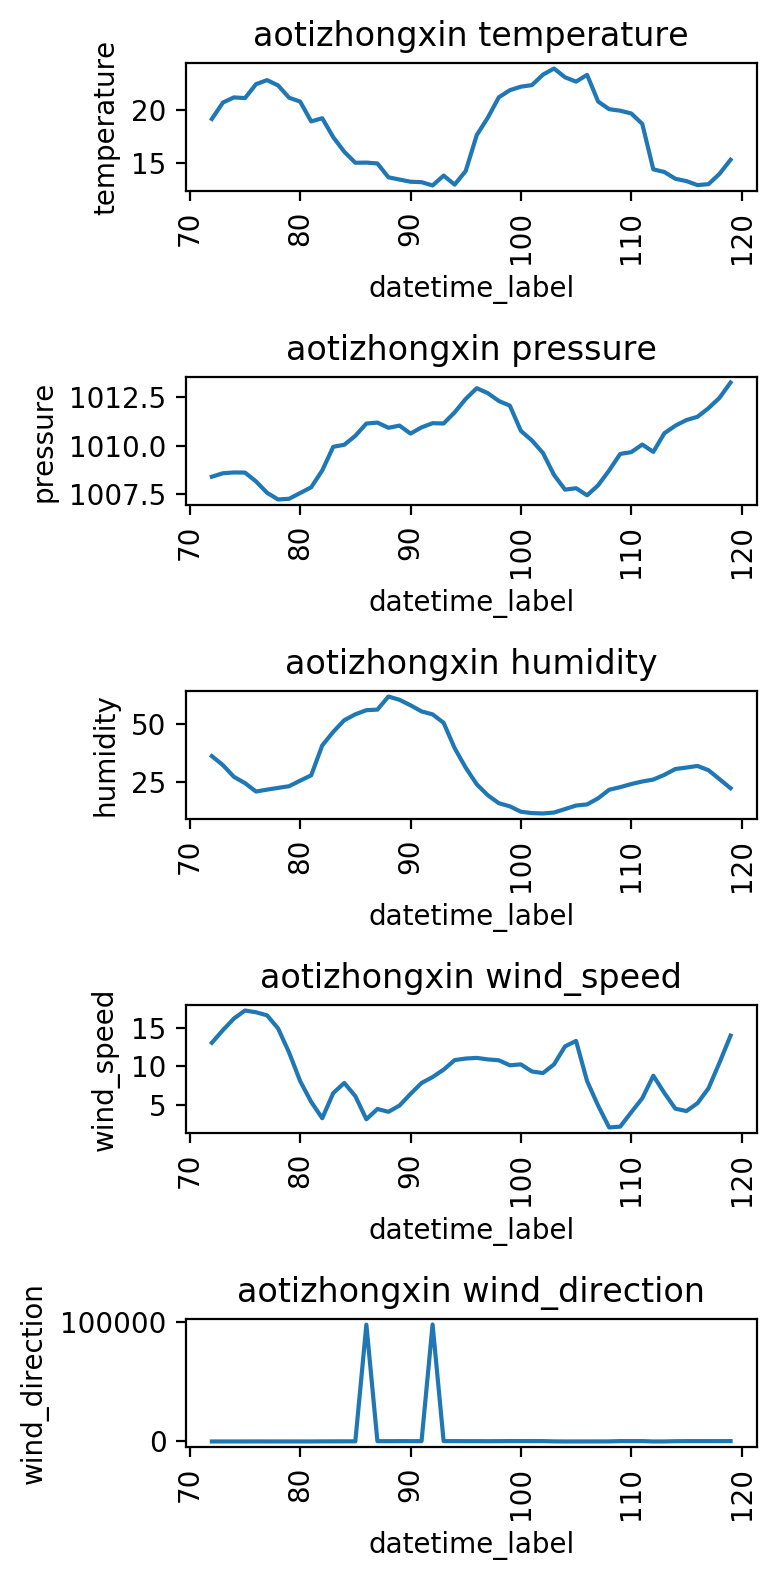

In [21]:
indicator = ['temperature', 'pressure', 'humidity', 'wind_speed', 'wind_direction']
temp = test_df.query('station_id=="aotizhongxin_aq"')

plt.figure(figsize=(4,8), dpi=200)
i = 1
for indic in indicator:
    plt.subplot(5,1,i)
    plt.plot(temp['datetime_label'], temp[indic])
    plt.title(f'aotizhongxin {indic}')
    plt.ylabel(indic)
    plt.xlabel('datetime_label')
    plt.xticks(rotation=90)
    i+=1
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'atzx_predict_weather_indocators.png'))
plt.show()

In [24]:
output_df = pd.DataFrame()
for target_station in station_list:
    station_name = target_station.split('_')[0]
    input_x = construct_train_xy(test_df, target_station, station_list, only_x=True)
    output = input_x[['station_id', 'test_id']]
    input_x = input_x.drop(['station_id', 'test_id'], axis=1)
    m_o3_1 = joblib.load(os.path.join(model_folder, f'{station_name}_o3_2.joblib'))
    m_o3_2 = joblib.load(os.path.join(model_folder, f'{station_name}_o3_3.joblib'))
    m_pm10_1 = joblib.load(os.path.join(model_folder, f'{station_name}_pm10_1.joblib'))
    m_pm25_1 = joblib.load(os.path.join(model_folder, f'{station_name}_pm25_1.joblib'))
    m_pm25_2 = joblib.load(os.path.join(model_folder, f'{station_name}_pm25_2.joblib'))
    m_pm25_3 = joblib.load(os.path.join(model_folder, f'{station_name}_pm25_3.joblib'))
    
    output['O3'] = (m_o3_1.predict(input_x)+m_o3_2.predict(input_x))/2
    output['PM2.5'] = (m_pm25_1.predict(input_x)+m_pm25_2.predict(input_x)+m_pm25_3.predict(input_x))/3
    output['PM10'] = m_pm10_1.predict(input_x)
    
    output_df = output_df.append(output)

# output_df = output_df.set_index('station_id')
output_df = output_df[['test_id', 'PM2.5', 'PM10', 'O3']]

In [30]:
output_df.to_csv(os.path.join(output_folder, 'submission.csv'), index = False)

In [27]:
# output_df

In [4]:
test_df = pd.read_csv(os.path.join(output_folder, 'test.zip'))

In [5]:
test_df

,Unnamed: 0,station_id,test_id,local_time,longitude,latitude,date,time,periodic_solar_term,periodic_time,NearTraffic,Others,SubUrban,Urban,datetime_label,temperature,pressure,humidity,wind_direction,wind_speed
0,0,aotizhongxin_aq,aotizhongxin_aq#0,2018-05-01 08:00:00,116.397,39.982,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.197473,1008.388377,36.256659,16.911237,13.044586
1,0,badaling_aq,badaling_aq#0,2018-05-01 08:00:00,115.988,40.365,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,15.421853,947.102110,36.374102,300.773515,11.613146
2,0,beibuxinqu_aq,beibuxinqu_aq#0,2018-05-01 08:00:00,116.174,40.090,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.000000,991.321403,33.085210,106.253983,11.362714
3,0,daxing_aq,daxing_aq#0,2018-05-01 08:00:00,116.404,39.718,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,20.159719,1010.166545,39.481207,27.886818,13.964596
4,0,dingling_aq,dingling_aq#0,2018-05-01 08:00:00,116.220,40.292,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.026391,981.076228,34.133923,349.134996,9.845308
5,0,donggaocun_aq,donggaocun_aq#0,2018-05-01 08:00:00,117.120,40.100,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,16.301867,997.948335,51.211854,42.960859,11.583609
6,0,dongsi_aq,dongsi_aq#0,2018-05-01 08:00:00,116.417,39.929,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.447052,1009.552345,37.772219,16.583779,13.129444
7,0,dongsihuan_aq,dongsihuan_aq#0,2018-05-01 08:00:00,116.483,39.939,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.071733,1010.503784,39.319019,13.930365,9.896808
8,0,fangshan_aq,fangshan_aq#0,2018-05-01 08:00:00,116.136,39.742,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.122892,1003.206164,37.382443,33.795813,10.355284
9,0,fengtaihuayuan_aq,fengtaihuayuan_aq#0,2018-05-01 08:00:00,116.279,39.863,2018-05-01,08:00:00,22.173109,16.970563,0,0,0,1,72,19.702392,1006.703516,35.436263,31.919175,10.215751
